In [1]:
import sys
print(sys.executable)
print(sys.path)

/uufs/chpc.utah.edu/common/home/u0035056/anaconda3/envs/atmos6010/bin/python
['/uufs/chpc.utah.edu/common/home/u0703457/public_html/dereks_homepage/Atmos_5340/test_dir', '/uufs/chpc.utah.edu/common/home/u0035056/anaconda3/envs/atmos6010/lib/python37.zip', '/uufs/chpc.utah.edu/common/home/u0035056/anaconda3/envs/atmos6010/lib/python3.7', '/uufs/chpc.utah.edu/common/home/u0035056/anaconda3/envs/atmos6010/lib/python3.7/lib-dynload', '', '/uufs/chpc.utah.edu/common/home/u0035056/anaconda3/envs/atmos6010/lib/python3.7/site-packages', '/uufs/chpc.utah.edu/common/home/u0035056/anaconda3/envs/atmos6010/lib/python3.7/site-packages/IPython/extensions', '/uufs/chpc.utah.edu/common/home/u0703457/.ipython']


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mcm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pygrib
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import add_timestamp
import windspharm
from windspharm.standard import VectorWind
from windspharm.tools import prep_data, recover_data, order_latdim
from windspharm.examples import example_data_path
from netCDF4 import Dataset
from netCDF4 import num2date
from datetime import datetime
import xarray as xr
import cfgrib
from cfgrib.xarray_store import open_dataset
from metpy.interpolate import cross_section

In [3]:
# format: /uufs/chpc.utah.edu/common/home/u0035056/atmos_6010_2020/data/2020082200/gfs.t00z.pgrb2.1p00.f000.nc
nc_f = 'gfs.t00z.pgrb2.1p00.f000.grib2'  # Your filename
path='/uufs/chpc.utah.edu/common/home/u0035056/atmos6010/data/2020092200/'

In [4]:
#get zonal wind. note some variables are in different level coordinates and have different numbers of levels
datau = xr.open_dataset(path+nc_f, engine='cfgrib', backend_kwargs=dict(filter_by_keys={'typeOfLevel': 'isobaricInhPa','shortName': 'u'}))
#see what is in there
#note that zonal wind has 31 vertical levels
datau

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 31, latitude: 181, longitude: 360)
Coordinates:
    time           datetime64[ns] ...
    step           timedelta64[ns] ...
  * isobaricInhPa  (isobaricInhPa) int64 1000 975 950 925 900 850 ... 7 5 3 2 1
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
    valid_time     datetime64[ns] ...
Data variables:
    u              (isobaricInhPa, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2020-09-22T08:52:07 GRIB to CDM+CF via cfgrib-0....

In [5]:
datav = xr.open_dataset(path+nc_f, engine='cfgrib', backend_kwargs=dict(filter_by_keys={'typeOfLevel': 'isobaricInhPa','shortName': 'v'}))
#datav

In [6]:
datar = xr.open_dataset(path+nc_f, engine='cfgrib', backend_kwargs=dict(filter_by_keys={'typeOfLevel': 'isobaricInhPa','shortName': 'r'}))
#datar

In [7]:
datat = xr.open_dataset(path+nc_f, engine='cfgrib', backend_kwargs=dict(filter_by_keys={'typeOfLevel': 'isobaricInhPa','shortName': 't'}))
#datat
#see what is in there
#note that t  has 33 vertical levels, extras are 40 and 15, ugh

In [8]:
datagh = xr.open_dataset(path+nc_f, engine='cfgrib', backend_kwargs=dict(filter_by_keys={'typeOfLevel': 'isobaricInhPa','shortName': 'gh'}))
#datagh

In [9]:
# Assign coor data to variable names
times = datau['time']
print(times.values)
timestamp=times.dt.strftime("%Y%m%d%H").values
print(timestamp)
lat = datau['latitude']
lon = datau['longitude']
levs = datau['isobaricInhPa'][0:23]
print(levs)
#cut out the time dimension and go from 1000 to 50 hPa
datau = datau.metpy.parse_cf().squeeze()
ua = datau['u'][0:23]
datav = datav.metpy.parse_cf().squeeze()
va = datav['v'][0:23]
datar = datar.metpy.parse_cf().squeeze()
ra = datar['r'][0:23]
datat = datat.metpy.parse_cf().squeeze()
ta = datat['t'][0:23]
datagh = datagh.metpy.parse_cf().squeeze()
datagh['gh'].attrs['units'] = 'meter'
ha = datagh['gh'][0:23]
#print(ta.values)
#print(gha.values)

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


2020-09-22T00:00:00.000000000
2020092200
<xarray.DataArray 'isobaricInhPa' (isobaricInhPa: 23)>
array([1000,  975,  950,  925,  900,  850,  800,  750,  700,  650,  600,  550,
        500,  450,  400,  350,  300,  250,  200,  150,  100,   70,   50])
Coordinates:
    time           datetime64[ns] 2020-09-22
    step           timedelta64[ns] 00:00:00
  * isobaricInhPa  (isobaricInhPa) int64 1000 975 950 925 900 ... 150 100 70 50
    valid_time     datetime64[ns] 2020-09-22
Attributes:
    long_name:         pressure
    units:             hPa
    positive:          down
    stored_direction:  decreasing
    standard_name:     air_pressure


In [10]:
#ua

In [11]:
#ta

In [12]:
#merge all into one xarray
data = xr.merge([ua,va,ta,ra,ha])
data

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 23, latitude: 181, longitude: 360)
Coordinates:
    time           datetime64[ns] 2020-09-22
    step           timedelta64[ns] 00:00:00
  * isobaricInhPa  (isobaricInhPa) int64 1000 975 950 925 900 ... 150 100 70 50
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
    valid_time     datetime64[ns] 2020-09-22
    crs            object Projection: latitude_longitude
Data variables:
    u              (isobaricInhPa, latitude, longitude) float32 ...
    v              (isobaricInhPa, latitude, longitude) float32 ...
    t              (isobaricInhPa, latitude, longitude) float32 ...
    r              (isobaricInhPa, latitude, longitude) float32 ...
    gh             (isobaricInhPa, latitude, longitude) float32 ...

In [13]:
#cross section
start = (50.0, -180.0)
end = (50.0, -70.0)
cross = cross_section(data, start, end).set_coords(('latitude', 'longitude'))
print(cross)

/uufs/chpc.utah.edu/common/home/u0035056/anaconda3/envs/atmos6010/lib/python3.7/site-packages/metpy/xarray.py:270: UserWarning: More than one time coordinate present for variable "u".
  + self._data_array.name + '".')


<xarray.Dataset>
Dimensions:        (index: 100, isobaricInhPa: 23)
Coordinates:
    time           datetime64[ns] 2020-09-22
    step           timedelta64[ns] 00:00:00
  * isobaricInhPa  (isobaricInhPa) int64 1000 975 950 925 900 ... 150 100 70 50
    valid_time     datetime64[ns] 2020-09-22
    crs            object Projection: latitude_longitude
    longitude      (index) float64 180.0 180.7 181.4 182.1 ... 288.6 289.3 290.0
    latitude       (index) float64 50.0 50.47 50.94 51.41 ... 50.94 50.47 50.0
  * index          (index) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
Data variables:
    u              (isobaricInhPa, index) float64 3.522 4.478 ... 8.263 8.32
    v              (isobaricInhPa, index) float64 -4.045 -4.59 ... -1.728 -1.484
    t              (isobaricInhPa, index) float64 280.4 280.3 ... 214.6 213.9
    r              (isobaricInhPa, index) float64 87.9 88.47 88.72 ... 1.249 1.4
    gh             (isobaricInhPa, index) float64 200.1 196.0 ... 2.076e+04


In [14]:
t, p, rh = xr.broadcast(cross['t'],cross['isobaricInhPa'],cross['r'])
theta = mpcalc.potential_temperature(p, t)
# These calculations return unit arrays, so put those back into DataArrays in our Dataset
cross['Potential_temperature'] = xr.DataArray(theta,
                                              coords=t.coords,
                                              dims=t.dims,
                                              attrs={'units': theta.units})

cross['t_wind'], cross['n_wind'] = mpcalc.cross_section_components(cross['u'],
                                                                   cross['v'])
print(cross)

<xarray.Dataset>
Dimensions:                (index: 100, isobaricInhPa: 23)
Coordinates:
    time                   datetime64[ns] 2020-09-22
    step                   timedelta64[ns] 00:00:00
  * isobaricInhPa          (isobaricInhPa) int64 1000 975 950 925 ... 100 70 50
    valid_time             datetime64[ns] 2020-09-22
    crs                    object Projection: latitude_longitude
    longitude              (index) float64 180.0 180.7 181.4 ... 289.3 290.0
    latitude               (index) float64 50.0 50.47 50.94 ... 50.94 50.47 50.0
  * index                  (index) int64 0 1 2 3 4 5 6 ... 93 94 95 96 97 98 99
Data variables:
    u                      (isobaricInhPa, index) float64 3.522 4.478 ... 8.32
    v                      (isobaricInhPa, index) float64 -4.045 ... -1.484
    t                      (isobaricInhPa, index) float64 280.4 280.3 ... 213.9
    r                      (isobaricInhPa, index) float64 87.9 88.47 ... 1.4
    gh                     (isobaricInhPa,

/uufs/chpc.utah.edu/common/home/u0035056/anaconda3/envs/atmos6010/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


FileNotFoundError: [Errno 2] No such file or directory: '../figs/gfs_cross_2020092200.png'

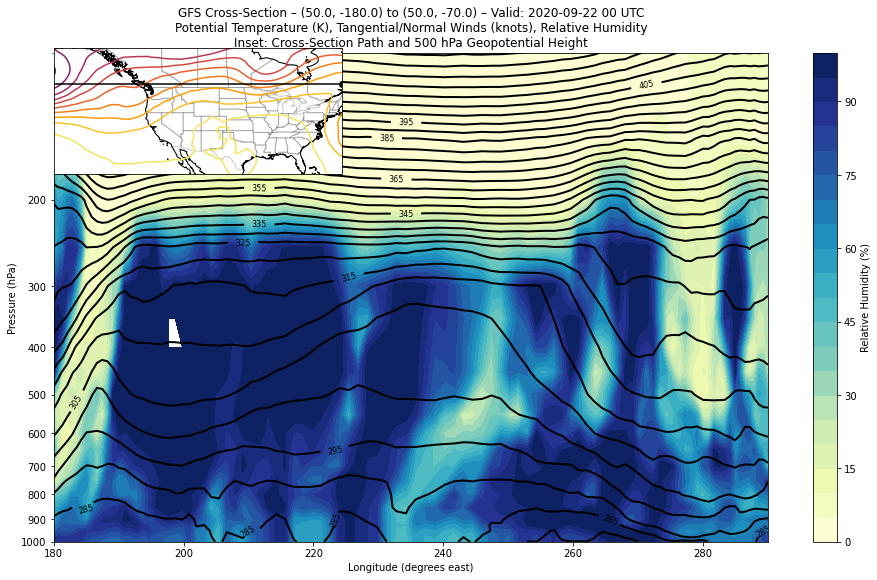

In [16]:
# Define the figure object and primary axes
fig = plt.figure(1, figsize=(16., 9.))
ax = plt.axes()

wind_slc_vert = list(range(0, 21))
wind_slc_horz = slice(5, 100, 5)
# Plot RH using contourf
rh_contour = ax.contourf(cross['longitude'], cross['isobaricInhPa'][wind_slc_vert], cross['r'][wind_slc_vert],
                         levels=np.arange(0, 105, 5), cmap='YlGnBu')
rh_colorbar = fig.colorbar(rh_contour)

# Plot potential temperature using contour, with some custom labeling
theta_contour = ax.contour(cross['longitude'], cross['isobaricInhPa'][wind_slc_vert], cross['Potential_temperature'][wind_slc_vert],
                           levels=np.arange(250, 450, 5), colors='k', linewidths=2)
theta_contour.clabel(theta_contour.levels[1::2], fontsize=8, colors='k', inline=1,
                     inline_spacing=8, fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot winds using the axes interface directly, with some custom indexing to make the barbs
# less crowded
#ax.barbs(cross['longitude'][wind_slc_horz], cross['isobaricInhPa'][wind_slc_vert],
#         cross['t_wind'][wind_slc_vert, wind_slc_horz],
#         cross['n_wind'][wind_slc_vert, wind_slc_horz], color='k')

# Adjust the y-axis to be logarithmic
ax.set_yscale('symlog')
ax.set_yticklabels(np.arange(1000, 100, -100))
ax.set_ylim(cross['isobaricInhPa'].max(), 100)
ax.set_yticks(np.arange(1000, 100, -100))

# Define the CRS and inset axes
data_crs = data['gh'].metpy.cartopy_crs
ax_inset = fig.add_axes([0.125, 0.665, 0.25, 0.25], projection=data_crs)

# Coordinates to limit map area
bounds = [(-150., -70., 25., 60.)]
ax_inset.set_extent(*bounds, crs=ccrs.PlateCarree())
# Plot geopotential height at 500 hPa using xarray's contour wrapper
ax_inset.contour(data['longitude'], data['latitude'], data['gh'].sel(isobaricInhPa=500.),
                 levels=np.arange(5100, 6000, 60), cmap='inferno')

# Plot the path of the cross section
endpoints = data_crs.transform_points(ccrs.Geodetic(),
                                      *np.vstack([start, end]).transpose()[::-1])
ax_inset.scatter(endpoints[:, 0], endpoints[:, 1], c='k', zorder=2)
ax_inset.plot(cross['longitude'], cross['latitude'], c='k', zorder=2)
ax_inset.plot(endpoints[:, 0], endpoints[:, 1], c='k', zorder=2)

# Add geographic features
ax_inset.coastlines()
ax_inset.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='k', alpha=0.2, zorder=0)

# Set the titles and axes labels
ax_inset.set_title('')
ax.set_title('GFS Cross-Section \u2013 {} to {} \u2013 Valid: {}\n'
             'Potential Temperature (K), Tangential/Normal Winds (knots), '
             'Relative Humidity\n'
             'Inset: Cross-Section Path and 500 hPa Geopotential Height'.format(
                 start, end, cross['time'].dt.strftime('%Y-%m-%d %H UTC').item()))
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('Longitude (degrees east)')
rh_colorbar.set_label('Relative Humidity (%)')
plot_file = '../figs/gfs_cross_'+ timestamp + '.png'
plt.savefig(plot_file)
plt.show()

In [ ]:
# Define the figure object and primary axes
fig = plt.figure(1, figsize=(16., 9.))
ax = plt.axes()

wind_slc_vert = list(range(0, 21))
wind_slc_horz = slice(5, 100, 5)
# Plot RH using contourf
rh_contour = ax.contourf(cross['longitude'], cross['isobaricInhPa'][wind_slc_vert], cross['r'][wind_slc_vert],
                         levels=np.arange(0, 105, 5), cmap='YlGnBu')
rh_colorbar = fig.colorbar(rh_contour)

# Plot  temperature using contour, with some custom labeling
cross['t'] = cross['t'] - 273.16
t_contour = ax.contour(cross['longitude'], cross['isobaricInhPa'][wind_slc_vert], cross['t'][wind_slc_vert],
                           levels=np.arange(-75,37.5, 7.5), colors='k', linewidths=2)
t_contour.clabel(t_contour.levels[1::2], fontsize=8, colors='k', inline=1,
                     inline_spacing=8, fmt='%0.1f', rightside_up=True, use_clabeltext=True)

# Plot winds using the axes interface directly, with some custom indexing to make the barbs
# less crowded
#ax.barbs(cross['longitude'][wind_slc_horz], cross['isobaricInhPa'][wind_slc_vert],
#         cross['t_wind'][wind_slc_vert, wind_slc_horz],
#         cross['n_wind'][wind_slc_vert, wind_slc_horz], color='k')

# Adjust the y-axis to be logarithmic
ax.set_yscale('symlog')
ax.set_yticklabels(np.arange(1000, 100, -100))
ax.set_ylim(cross['isobaricInhPa'].max(), 100)
ax.set_yticks(np.arange(1000, 100, -100))

# Define the CRS and inset axes
data_crs = data['gh'].metpy.cartopy_crs
ax_inset = fig.add_axes([0.125, 0.665, 0.25, 0.25], projection=data_crs)

# Coordinates to limit map area
bounds = [(-150., -70., 25., 60.)]
ax_inset.set_extent(*bounds, crs=ccrs.PlateCarree())
# Plot geopotential height at 500 hPa using xarray's contour wrapper
ax_inset.contour(data['longitude'], data['latitude'], data['gh'].sel(isobaricInhPa=500.),
                 levels=np.arange(5100, 6000, 60), cmap='inferno')

# Plot the path of the cross section
endpoints = data_crs.transform_points(ccrs.Geodetic(),
                                      *np.vstack([start, end]).transpose()[::-1])
ax_inset.scatter(endpoints[:, 0], endpoints[:, 1], c='k', zorder=2)
ax_inset.plot(cross['longitude'], cross['latitude'], c='k', zorder=2)
ax_inset.plot(endpoints[:, 0], endpoints[:, 1], c='k', zorder=2)

# Add geographic features
ax_inset.coastlines()
ax_inset.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='k', alpha=0.2, zorder=0)

# Set the titles and axes labels
ax_inset.set_title('')
ax.set_title('GFS Cross-Section \u2013 {} to {} \u2013 Valid: {}\n'
             'Temperature (C), Tangential/Normal Winds (knots), '
             'Relative Humidity\n'
             'Inset: Cross-Section Path and 500 hPa Geopotential Height'.format(
                 start, end, cross['time'].dt.strftime('%Y-%m-%d %H UTC').item()))
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('Longitude (degrees east)')
rh_colorbar.set_label('Relative Humidity (%)')
plot_file = '../figs/gfs_cross_'+ timestamp + '.png'
plt.savefig(plot_file)
plt.show()